## Week 1##

### Using Xarray to import ###

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import xarray as xr


In [2]:
path = '../data/riskindex/netcdf/max_temperature/'

In [3]:
#load 'observed' temperatures for LONDON
data_era = xr.open_dataarray(path + 'Madrid_ERAI.nc')
data_era

<xarray.DataArray (time: 13870)>
array([284.25812, 281.57172, 280.14166, ..., 285.6272 , 285.39752, 282.95285],
      dtype=float32)
Coordinates:
    surface      float32 ...
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2017-12-31
    day_of_year  (time) int64 ...
    year         (time) int64 ...
    lon          float64 ...
    lat          float64 ...
Attributes:
    long_name:     Maximum 2 metre temperature since previous post-processing
    units:         K
    cell_methods:  day_of_year: year: maximum
    city:          Madrid
    rcp:           None
    model_type:    era

In [4]:
# Load climate model temperature
data_gcm = xr.open_dataarray(path + 'Madrid_rcp45.nc')
data_gcm

<xarray.DataArray (time: 25915)>
array([287.283813, 285.842689, 283.586381, ..., 282.861178, 279.959751,
       281.916748])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2050-12-31
    lon      float64 ...
    lat      float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K
    original_name:  mo: m01s03i236
    cell_methods:   time: maximum
    cell_measures:  area: areacella
    city:           Madrid
    rcp:            rcp45
    model_type:     gcm

### Converting to pandas dataframe ### 

In [5]:
cd ../

/space/rp542/Team_project/urban-climate-downloader


In [6]:
from downloader import dataprocessing
#ERA-Interim
df_era = dataprocessing.da_to_df(data_era)
df_era['temp_celcius'] = df_era['data'] - 273
df_era.head()

,data,temp_celcius
time,,
1980-01-01,284.258118,11.258118
1980-01-02,281.571716,8.571716
1980-01-03,280.141663,7.141663
1980-01-04,280.547821,7.547821
1980-01-05,279.989441,6.989441


In [34]:
# GCM
df_gcm = dataprocessing.da_to_df(data_gcm)
df_gcm['temp_celcius'] = df_gcm['data'] - 273
df_gcm.head()

,data,temp_celcius
time,,
1980-01-01,287.283813,14.283813
1980-01-02,285.842689,12.842689
1980-01-03,283.586381,10.586381
1980-01-04,282.834330,9.834330
1980-01-05,281.538216,8.538216


### Bias Correction ###

In [35]:
df_era_past30 = df_era['1980-01-01':'2010-12-31'] #past and future period have the same number of years (30 here)
df_gcm_past30 = df_gcm['1980-01-01':'2010-12-31']
df_gcm_fut30 = df_gcm['2020-01-01':'2050-12-31']



In [36]:
o_ref = df_era_past30['temp_celcius'].copy()
t_ref = df_gcm_past30['temp_celcius'].copy()
t_raw = df_gcm_fut30['temp_celcius'].copy()

o_ref_datashift = t_raw - t_raw.to_numpy() + o_ref.to_numpy()  #what is this doing -> shifting the o_ref times from the ref to the future


o_ref_mean = df_era_past30.temp_celcius.mean()
t_ref_mean = df_gcm_past30.temp_celcius.mean()
t_raw_mean = df_gcm_fut30.temp_celcius.mean()

o_ref_std = df_era_past30.temp_celcius.std()
t_ref_std = df_gcm_past30.temp_celcius.std()
t_raw_std = df_gcm_fut30.temp_celcius.std()

In [37]:
t_sh = t_raw + (o_ref_mean - t_ref_mean)
t_bc = o_ref_mean + (o_ref_std / t_ref_std) * (t_raw - t_ref_mean)
t_del = o_ref_datashift + (t_raw_mean - t_ref_mean)
t_cf = t_raw + (t_raw_std / t_ref_std) * (o_ref_datashift - t_ref_mean)


### Quantile Mapping ###

In [38]:
from tqdm import tqdm_notebook as tqdm
quantile_factors = []
for quantile in range(0,101):
    quantile_as_fraction = quantile / 100.0
    quantile_factor = df_era_past30.quantile(quantile_as_fraction)['data'] / df_gcm_past30.quantile(quantile_as_fraction)['data']
    quantile_factors.append(quantile_factor)

In [39]:
df_era_past30.quantile(0.3)['data']

285.0570434570312

In [40]:
def apply_mapping(factors, data_frame):
    quantile_values = []
    for quantile in range(0,101):
        quantile_as_fraction = quantile / 100.0
        quantile_values.append(data_frame.quantile(quantile_as_fraction).data[0])
    
    df_quantil e_mapped = data_frame.copy()
    for data_index, datum in enumerate(data_frame.data):
        for i in range(1,101):
            quantile_as_fraction = i / 100.0
            upper_limit = quantile_values[i]
            lower_limit = quantile_values[i-1]
            if datum > lower_limit and datum <= upper_limit:
                df_quantile_mapped.data[data_index] = df_quantile_mapped.data[data_index] * quantile_factors[i]
            
    return df_quantile_mapped

df_gcm_quantile_mapped = apply_mapping(quantile_factors, df_gcm_past30)

/space/rp542/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


### Plots ###

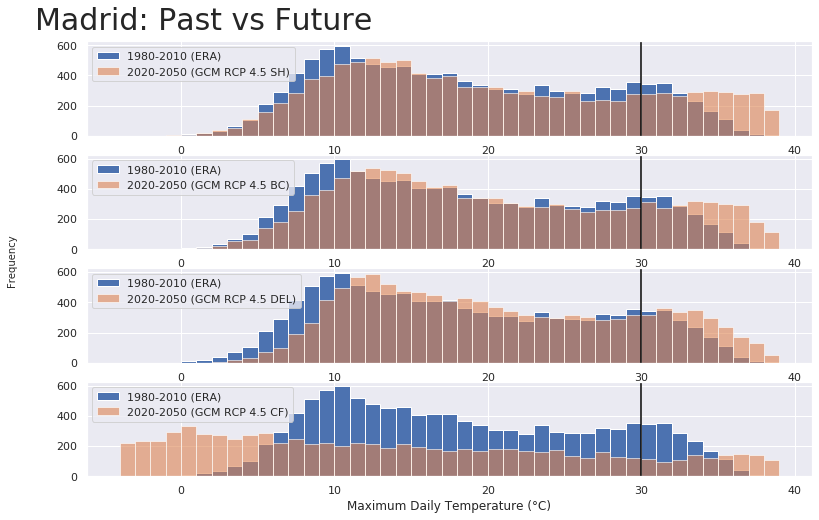

In [41]:
mybins = np.arange(-4,40,1)


fig, ax = plt.subplots(4,1,figsize = (13,8))

fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
plt.xlabel('Maximum Daily Temperature (°C)')
fig.suptitle('Madrid: Past vs Future', fontsize=30, x = 0.25, y =0.94)

for axis in ax:
    axis.axvline(x = 30, c = 'black')
    axis.hist(df_era_past30.temp_celcius, label = '1980-2010 (ERA)', alpha = 1, bins=mybins)


ax[0].hist(t_sh, label = '2020-2050 (GCM RCP 4.5 SH)', alpha = 0.6, bins = mybins)

ax[1].hist(t_bc, label = '2020-2050 (GCM RCP 4.5 BC)', alpha = 0.6, bins = mybins)

ax[2].hist(t_del, label = '2020-2050 (GCM RCP 4.5 DEL)', alpha = 0.6, bins = mybins)

ax[3].hist(t_cf, label = '2020-2050 (GCM RCP 4.5 CF)', alpha = 0.6, bins = mybins)

for axis in ax:
    axis.legend(loc = 'upper left')


plt.rc('font', size=20)
plt.rc('axes', labelsize=20) 
plt.show()


In [87]:
fig.savefig('madrid_future.png', dpi=160, bbox_inches='tight', transparent=True)
